In [760]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np

from matplotlib import rcParams

rcParams["figure.dpi"] = 300

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

from labellines import labelLines

from the_bootstrap_approach.dataplate import DataPlate
from the_bootstrap_approach.conditions import (
    Mixture,
    Conditions,
    FullThrottleConditions,
    PartialThrottleConditions,
)
from the_bootstrap_approach.equations import *
from the_bootstrap_approach.propeller_chart import propeller_efficiency

N51SW = DataPlate(
    # Airplane configuration. e.g., flaps/gear position.
    "Flaps Up",
    # S, reference wing area (ft^2).
    170,
    # B, wing span (ft).
    425.11 / 12,
    # C_{D0}, parasite drag coefficient (depends on flaps/gear configuration).
    0.0357162948271769,
    # e, airplane efficiency factor (possibly depends on flaps configuration).
    0.673966174425770,
    # P_0, rated MSL shaft power at rated RPM.
    235,
    # N_0, rated MSL full-throttle RPM.
    2400,
    # C, engine power altitude dropoff parameter, the porportion of indicated
    # power that goes to engine friction losses (close to 0.12).
    0.12,
    # c, brake specific full consumption rate (lbm/HP/HR).
    # > Model O-540-J3A5D Engines – Manual leaning is permitted at cruise
    # > conditions up to 85% power resulting in a BSFC of .420 lbs./BHP./hr. at
    # > best economy and .460 lbs./BHP./hr. at best power. Minimum allowable
    # > BSFC at take-off and climb conditions is .500 lbs./BHP./hr.
    (0.460, 0.420, 0.500),
    # d, propeller diameter (ft).
    80 / 12,
    # BAF, blade activity factor.
    101.600808244411,
    # Z, ratio of fuselage diameter (taken one propeller diameter behind the
    # propeller) to propeller diameter.
    ((43 + (5 / 16) + 48) / 2) / 80,
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/folders/nb/_zfr7tq51kb3wqxqx6474q900000gn/T/ipykernel_5890/1189923862.py:5: RuntimeWarning: divide by zero encountered in true_divide
  return operating_conditions.g * air_speed ** 3 + operating_conditions.h / air_speed


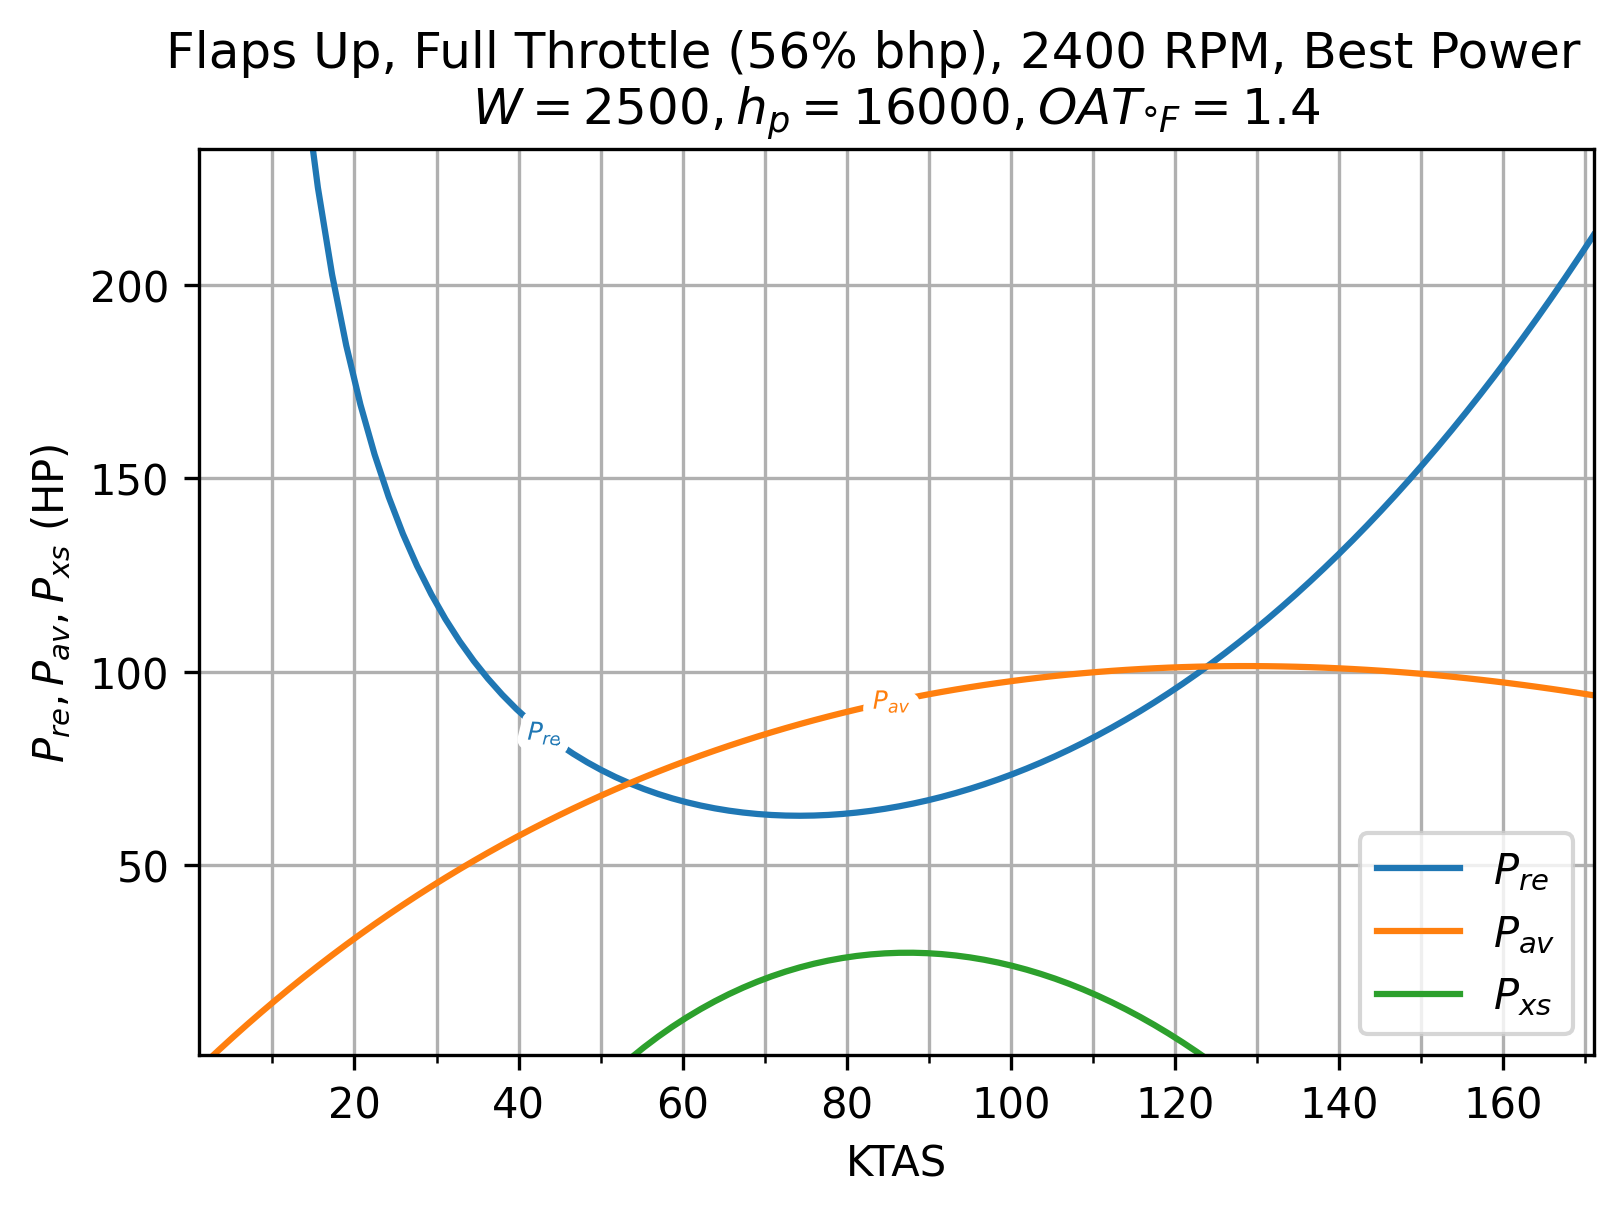

In [761]:
def power_required(operating_conditions, air_speed):
    """Determine power required :math:`P_{re}` to overcome the total drag force
    at air speed :math:`V`."""
    # $P_{re} = {GV}^3 + H/V$
    return operating_conditions.g * air_speed ** 3 + operating_conditions.h / air_speed


def power_available(dataplate: DataPlate, operating_conditions: Conditions, air_speed):
    eta = propeller_efficiency(
        dataplate.z_ratio,
        propeller_advance_ratio(
            air_speed, operating_conditions.propeller_rps, dataplate.propeller_diameter
        ),
        propeller_power_coefficient(
            operating_conditions.power,
            operating_conditions.atmospheric_density,
            operating_conditions.propeller_rps,
            dataplate.propeller_diameter,
        ),
        power_adjustment_factor_x(dataplate.total_activity_factor),
    )

    return eta * operating_conditions.power


def tas(cas, relative_atmospheric_density):
    return cas / math.sqrt(relative_atmospheric_density)


def cas(tas, relative_atmospheric_density):
    return math.sqrt(relative_atmospheric_density) * tas


def kn_to_fts(kn):
    return kn / 0.5924838


operating_conditions = FullThrottleConditions(
    N51SW, 2500, 16000, c_to_f(15 - (16 * 2)), Mixture.BEST_POWER, 2400
)

fig, ax = plt.subplots()

# $V_{NE}$ for N51SW is 171 KCAS
never_exceed_speed = 171
ktas = np.linspace(0, never_exceed_speed, 100)

p_re = power_required(operating_conditions, kn_to_fts(ktas)) / 550
ax.plot(ktas, p_re, label=r"$P_{re}$")

p_av = (
    power_available(
        N51SW,
        operating_conditions,
        kn_to_fts(ktas),
    )
    / 550
)
ax.plot(ktas, p_av, label=r"$P_{av}$")

p_xs = p_av - p_re
ax.plot(ktas, p_xs, label=r"$P_{xs}$")

labelLines(plt.gca().get_lines(), zorder=2.5, fontsize=6)

plt.suptitle(
    f"{N51SW.configuration}, {operating_conditions.desc} ({operating_conditions.power / N51SW.rated_full_throttle_engine_power * 100:.0f}% bhp), {operating_conditions.engine_rpm} RPM, {operating_conditions.mixture.value}"
)

ax.set(
    xlabel="KTAS",
    ylabel=r"$P_{re}, P_{av}, P_{xs}$ (HP)",
    title=f"$W = {operating_conditions.gross_aircraft_weight}, h_p = {operating_conditions.pressure_altitude}, {{OAT_{{\degree{{F}}}}}} = {operating_conditions.oat_f:.1f}$",
)

ax.grid(True, which="both")

ax.xaxis.set_minor_locator(AutoMinorLocator((2)))

ax.set_xlim([1, never_exceed_speed])
ax.set_ylim([1, N51SW.rated_full_throttle_engine_horsepower])

plt.legend()

plt.show()


In [762]:
from tabulate import tabulate


def bootstrap_cruise_performance_table(
    dataplate: DataPlate, operating_conditions: Conditions, min, max, step
):
    kcas = np.arange(min, max, step)
    ktas = tas(kcas, operating_conditions.relative_atmospheric_density)
    vt = kn_to_fts(ktas)

    pre = power_required(operating_conditions, vt)
    pav = power_available(dataplate, operating_conditions, vt)
    pxs = pav - pre

    thrust = pav / vt
    drag = pre / vt
    excess_thrust = thrust - drag

    eta = propeller_efficiency(
        dataplate.z_ratio,
        propeller_advance_ratio(
            vt,
            operating_conditions.propeller_rps,
            dataplate.propeller_diameter,
        ),
        propeller_power_coefficient(
            operating_conditions.power,
            operating_conditions.atmospheric_density,
            operating_conditions.propeller_rps,
            dataplate.propeller_diameter,
        ),
        power_adjustment_factor_x(dataplate.total_activity_factor),
    )

    h = 60 * excess_thrust * vt / operating_conditions.gross_aircraft_weight
    y = (180 / math.pi) * np.arcsin(
        excess_thrust / operating_conditions.gross_aircraft_weight
    )
    ftnm = h / (ktas / 60)

    if type(operating_conditions) == FullThrottleConditions:
        # %bhp and GPH at full throttle for these operating conditions.
        # TODO: What happens if someone brings RPM back? Does this still work?
        # Or, since we're already multiplying by ETA, are we all good?
        pbhp = ((pav / eta) / dataplate.rated_full_throttle_engine_power) * 100
        gph = (operating_conditions.bsfc * (pav / eta) / 550) / 6
    else:
        # %bhp and GPH required to maintain level flight at this TAS.
        pbhp = ((pre / eta) / dataplate.rated_full_throttle_engine_power) * 100
        gph = (operating_conditions.bsfc * (pre / eta) / 550) / 6
    mpg = ktas / gph

    return zip(kcas, ktas, eta, thrust, drag, h, y, ftnm, pxs, pbhp, gph, mpg)


operating_conditions = FullThrottleConditions(
    N51SW, 2500, 0, 59, Mixture.BEST_POWER, 2400
)

table = bootstrap_cruise_performance_table(N51SW, operating_conditions, 60, 180, 0.5)

print(
    f"{N51SW.configuration}, {operating_conditions.desc} ({operating_conditions.power / N51SW.rated_full_throttle_engine_power * 100:.0f}% bhp), {operating_conditions.engine_rpm} RPM, {operating_conditions.mixture.value}"
)
print(
    f"$W = {operating_conditions.gross_aircraft_weight}, h_p = {operating_conditions.pressure_altitude}, {{OAT_{{\degree{{F}}}}}} = {operating_conditions.oat_f:.1f}$",
)
print(
    tabulate(
        table,
        headers=[
            "KCAS",
            "KTAS",
            "η (Propulsive Efficiency)",
            "T (lb)",
            "D (lb)",
            "Rate of Climb (FPM)",
            "Flight Path Angle Correction (Deg)",
            "ft/nm",
            "P_xs",
            "%bhp",
            "gph",
            "mpg",
        ],
        tablefmt="fancy_grid",
    )
)


Flaps Up, Full Throttle (100% bhp), 2400 RPM, Best Power
$W = 2500, h_p = 0, {OAT_{\degree{F}}} = 59.0$
╒════════╤════════╤═════════════════════════════╤══════════╤══════════╤═══════════════════════╤══════════════════════════════════════╤════════════╤═════════════╤════════╤═════════╤═════════╕
│   KCAS │   KTAS │   η (Propulsive Efficiency) │   T (lb) │   D (lb) │   Rate of Climb (FPM) │   Flight Path Angle Correction (Deg) │      ft/nm │        P_xs │   %bhp │     gph │     mpg │
╞════════╪════════╪═════════════════════════════╪══════════╪══════════╪═══════════════════════╪══════════════════════════════════════╪════════════╪═════════════╪════════╪═════════╪═════════╡
│   60   │   60   │                    0.562883 │  718.413 │  266.981 │             1097.18   │                           10.4031    │ 1097.18    │   45715.8   │    100 │ 18.0167 │ 3.33025 │
├────────┼────────┼─────────────────────────────┼──────────┼──────────┼───────────────────────┼─────────────────────────────────────

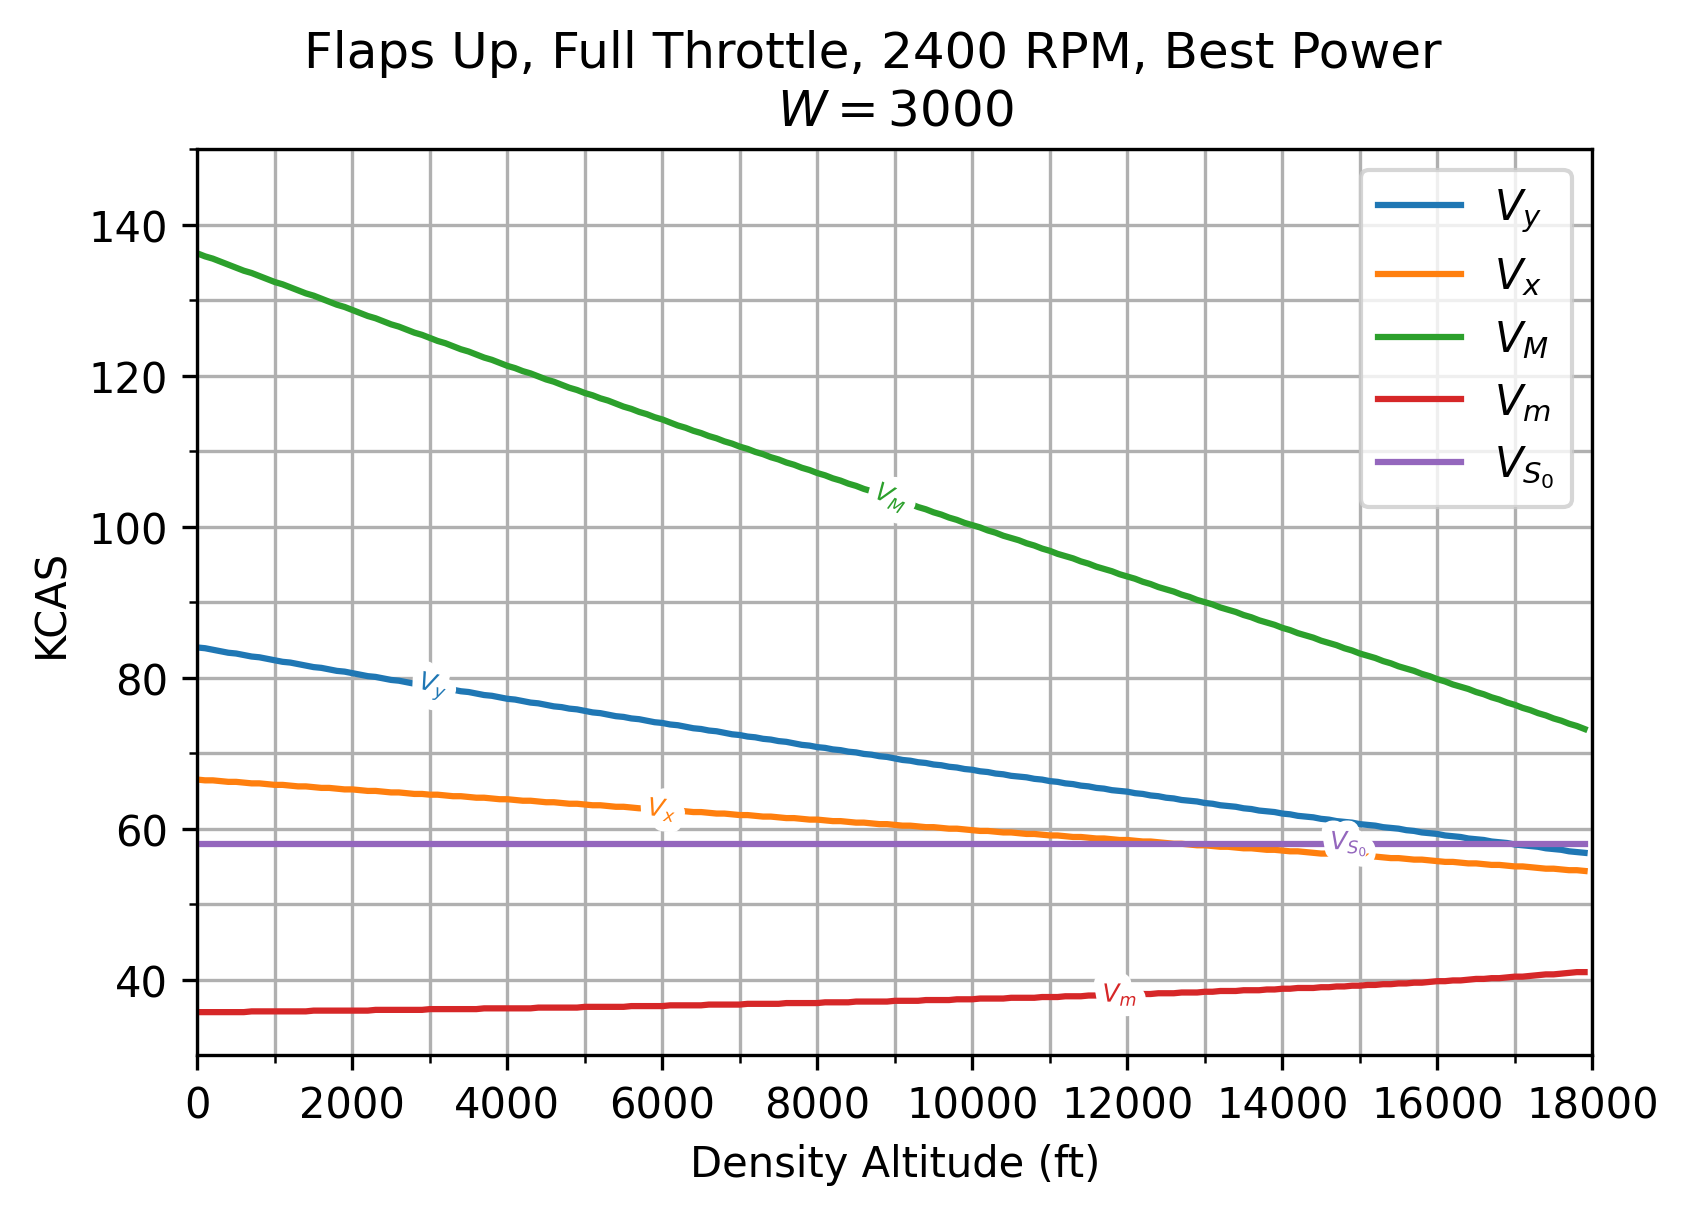

In [763]:
operating_conditions = FullThrottleConditions(
    N51SW, 3000, 0, 59, Mixture.BEST_POWER, 2400
)

pressure_altitude = np.arange(0, 18000, 100)

vy = []
vx = []
max_level_flight_speed = []
min_level_flight_speed = []
vs = []

for i in pressure_altitude:
    operating_conditions.pressure_altitude = i
    operating_conditions.oat_f = 59.0 - (i / 1000 * 3.5)

    table = np.array(
        list(
            bootstrap_cruise_performance_table(
                N51SW, operating_conditions, 30, 150, 0.1
            )
        )
    )

    # Vx, best rate of climb.
    climb_angle = table[:, 6]
    max_climb = climb_angle.argmax()
    vx.append(table[max_climb][0])

    # Vy, best angle of climb.
    roc = table[:, 5]
    index_of_highest_roc = roc.argmax()
    vy.append(table[index_of_highest_roc][0])

    # Vm, minimum level flight speed (in practice, Vm seldom occurs, because the
    # power-on stall speed is usually much higher).
    roc_before_peak = roc[:index_of_highest_roc]
    index_min_level_flight_speed = np.where(
        roc_before_peak > 0, roc_before_peak, np.inf
    ).argmin()
    min_level_flight_speed.append(table[index_min_level_flight_speed][0])

    # VM, maximum level flight speed.
    roc_after_peak = roc[index_of_highest_roc:]
    index_max_level_flight_speed = np.where(
        roc_after_peak > 0, roc_after_peak, np.inf
    ).argmin()
    max_level_flight_speed.append(
        table[index_of_highest_roc + index_max_level_flight_speed][0]
    )

    # V_{S_0}, stall speed in the landing configuration.
    vs.append(58)

fig, ax = plt.subplots()

ax.plot(pressure_altitude, vy, label=r"$V_y$")
ax.plot(pressure_altitude, vx, label=r"$V_x$")
ax.plot(pressure_altitude, max_level_flight_speed, label=r"$V_M$")
ax.plot(pressure_altitude, min_level_flight_speed, label=r"$V_m$")
ax.plot(pressure_altitude, vs, label=r"$V_{S_0}$")

labelLines(plt.gca().get_lines(), zorder=2.5, fontsize=6)

plt.suptitle(
    f"{N51SW.configuration}, {operating_conditions.desc}, {operating_conditions.engine_rpm} RPM, {operating_conditions.mixture.value}"
)

ax.set(
    xlabel="Density Altitude (ft)",
    ylabel="KCAS",
    title=f"$W = {operating_conditions.gross_aircraft_weight}$",
)

ax.grid(True, which="both")

ax.xaxis.set_minor_locator(AutoMinorLocator((2)))
ax.yaxis.set_minor_locator(AutoMinorLocator((2)))

ax.set_xlim([0, 18000])
ax.set_ylim([30, 150])

plt.legend()

plt.show()


In [764]:
N4697K = DataPlate(
    # Airplane configuration. e.g., flaps/gear position.
    "Flaps/Gear Up/Up",
    # S, reference wing area (ft^2).
    174,
    # B, wing span (ft).
    36,
    # C_{D0}, parasite drag coefficient (depends on flaps/gear configuration).
    0.02874,
    # e, airplane efficiency factor (possibly depends on flaps configuration).
    0.7200,
    # P_0, rated MSL shaft power at rated RPM.
    235,
    # N_0, rated MSL full-throttle RPM.
    2400,
    # C, engine power altitude dropoff parameter, the porportion of indicated
    # power that goes to engine friction losses (close to 0.12).
    0.12,
    # c, brake specific full consumption rate (lbm/HP/HR).
    (0.480, 0.430, 0.500),
    # d, propeller diameter (ft).
    6.83,
    # BAF, blade activity factor.
    97.95,
    # Z, ratio of fuselage diameter (taken one propeller diameter behind the
    # propeller) to propeller diameter.
    0.688,
)

operating_conditions = PartialThrottleConditions(
    N4697K,
    3100,
    8000,
    c_to_f(15 - (8000 / 1000 * 2)),
    Mixture.BEST_POWER,
    2300,
    235 * 0.65 * 550,
)

table = list(
    bootstrap_cruise_performance_table(N4697K, operating_conditions, 60, 180, 0.5)
)

assert math.isclose(
    table[0][1],
    67.6,
    # of 1 significant digits
    abs_tol=10 ** -1,
)
assert math.isclose(
    table[0][2],
    0.6166,
    # of 1 significant digits
    abs_tol=10 ** -4,
)
assert math.isclose(
    table[0][3],
    453,
    # of 0 significant digits
    abs_tol=10 ** -0,
)
assert math.isclose(
    table[0][4],
    329,
    # of 0 significant digits
    abs_tol=10 ** -0,
)
assert math.isclose(
    table[0][5],
    273.2,
    # of 0 significant digits
    abs_tol=10 ** -0,
)
assert math.isclose(
    table[0][6],
    2.28,
    # of 0 significant digits
    abs_tol=10 ** -2,
)
